In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    num_classes = 100
    input_shape = (32, 32, 3)
    early_stopping_patience=5
    # Configure the hyperparameters
    weight_decay = 0.0001
    batch_size = 128
    num_epochs = 200
    dropout_rate = 0.2
    image_size = 64  # We'll resize input images to this size.
    patch_size = 8  # Size of the patches to be extracted from the input images.
    num_patches = (image_size // patch_size) ** 2  # Size of the data array.
    embedding_dim = 256  # Number of hidden units.
    num_blocks = 4  # Number of blocks.
    learning_rate = 0.005

In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow_addons as tfa

/home/ml/anaconda3/envs/ml_tf_torch/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


# Prepare the data

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


# Configure the hyperparameters

In [5]:
print(f"Image size: {CFG.image_size} X {CFG.image_size} = {CFG.image_size ** 2}")
print(f"Patch size: {CFG.patch_size} X {CFG.patch_size} = {CFG.patch_size ** 2} ")
print(f"Patches per image: {CFG.num_patches}")
print(f"Elements per patch (3 channels): {(CFG.patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


# Build a classification model

In [6]:
def build_classifier(blocks, positional_encoding=False):
    inputs = tf.keras.layers.Input(shape=CFG.input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(CFG.patch_size, CFG.num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = tf.keras.layers.Dense(units=CFG.embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=CFG.num_patches, delta=1)
        position_embedding = tf.keras.layers.Embedding(
            input_dim=CFG.num_patches, output_dim=CFG.embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = tf.keras.layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = tf.keras.layers.Dropout(rate=CFG.dropout_rate)(representation)
    # Compute logits outputs.
    logits = tf.keras.layers.Dense(CFG.num_classes)(representation)
    # Create the Keras model.
    return tf.keras.Model(inputs=inputs, outputs=logits)

# Define an experiment

In [7]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                          factor=0.7,
                                                          min_delta=0.001,
                                                          patience=3,
                                                          mode="auto")
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=CFG.early_stopping_patience,
        restore_best_weights=True,
        min_delta=0.0001,
    )
    # Fit the model.
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=CFG.batch_size,
        epochs=CFG.num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduceLROnPlat],
    )

    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

# Use data augmentation

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(CFG.image_size, CFG.image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implement patch extraction as a layer

In [9]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

# Implement the MLP-Mixer module

In [10]:
class MLPMixerLayer(tf.keras.layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mlp1 = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=CFG.num_patches),
                tfa.layers.GELU(),
                tf.keras.layers.Dense(units=CFG.num_patches),
                tf.keras.layers.Dropout(rate=CFG.dropout_rate),
            ]
        )
        self.mlp2 = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=CFG.num_patches),
                tfa.layers.GELU(),
                tf.keras.layers.Dense(units=CFG.embedding_dim),
                tf.keras.layers.Dropout(rate=CFG.dropout_rate),
            ]
        )
        self.normalize = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

# Build, train, and evaluate the MLP-Mixer model

In [11]:
mlpmixer_blocks = tf.keras.Sequential(
    [MLPMixerLayer(CFG.num_patches, CFG.embedding_dim, CFG.dropout_rate) for _ in range(CFG.num_blocks)]
)

mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

Epoch 1/200
352/352 [==============================] - 6s 9ms/step - loss: 3.8600 - acc: 0.1127 - top5-acc: 0.3221 - val_loss: 3.5001 - val_acc: 0.1754 - val_top5-acc: 0.4404 - lr: 0.0050
Epoch 2/200
352/352 [==============================] - 3s 8ms/step - loss: 3.3875 - acc: 0.1864 - top5-acc: 0.4598 - val_loss: 3.3391 - val_acc: 0.2058 - val_top5-acc: 0.4808 - lr: 0.0050
Epoch 3/200
352/352 [==============================] - 3s 8ms/step - loss: 3.1951 - acc: 0.2240 - top5-acc: 0.5100 - val_loss: 3.0718 - val_acc: 0.2612 - val_top5-acc: 0.5516 - lr: 0.0050
Epoch 4/200
352/352 [==============================] - 3s 8ms/step - loss: 3.0395 - acc: 0.2546 - top5-acc: 0.5516 - val_loss: 2.9220 - val_acc: 0.2768 - val_top5-acc: 0.5940 - lr: 0.0050
Epoch 5/200
352/352 [==============================] - 3s 8ms/step - loss: 2.9256 - acc: 0.2714 - top5-acc: 0.5776 - val_loss: 2.8552 - val_acc: 0.3004 - val_top5-acc: 0.6122 - lr: 0.0050
Epoch 6/200
352/352 [==============================] - 3s 8m

352/352 [==============================] - 3s 8ms/step - loss: 1.7463 - acc: 0.5238 - top5-acc: 0.8179 - val_loss: 2.0118 - val_acc: 0.4890 - val_top5-acc: 0.7726 - lr: 0.0017
Epoch 45/200
352/352 [==============================] - 3s 8ms/step - loss: 1.7257 - acc: 0.5238 - top5-acc: 0.8240 - val_loss: 2.0453 - val_acc: 0.4826 - val_top5-acc: 0.7762 - lr: 0.0017
Epoch 46/200
352/352 [==============================] - 3s 8ms/step - loss: 1.7282 - acc: 0.5225 - top5-acc: 0.8243 - val_loss: 2.0569 - val_acc: 0.4774 - val_top5-acc: 0.7714 - lr: 0.0017
Epoch 47/200
352/352 [==============================] - 3s 8ms/step - loss: 1.7160 - acc: 0.5289 - top5-acc: 0.8258 - val_loss: 2.0131 - val_acc: 0.4792 - val_top5-acc: 0.7736 - lr: 0.0017
Epoch 48/200
352/352 [==============================] - 3s 9ms/step - loss: 1.6568 - acc: 0.5438 - top5-acc: 0.8362 - val_loss: 1.9774 - val_acc: 0.4894 - val_top5-acc: 0.7772 - lr: 0.0012
Epoch 49/200
352/352 [==============================] - 3s 8ms/step 

1/1 [==============================] - 0s 45ms/step


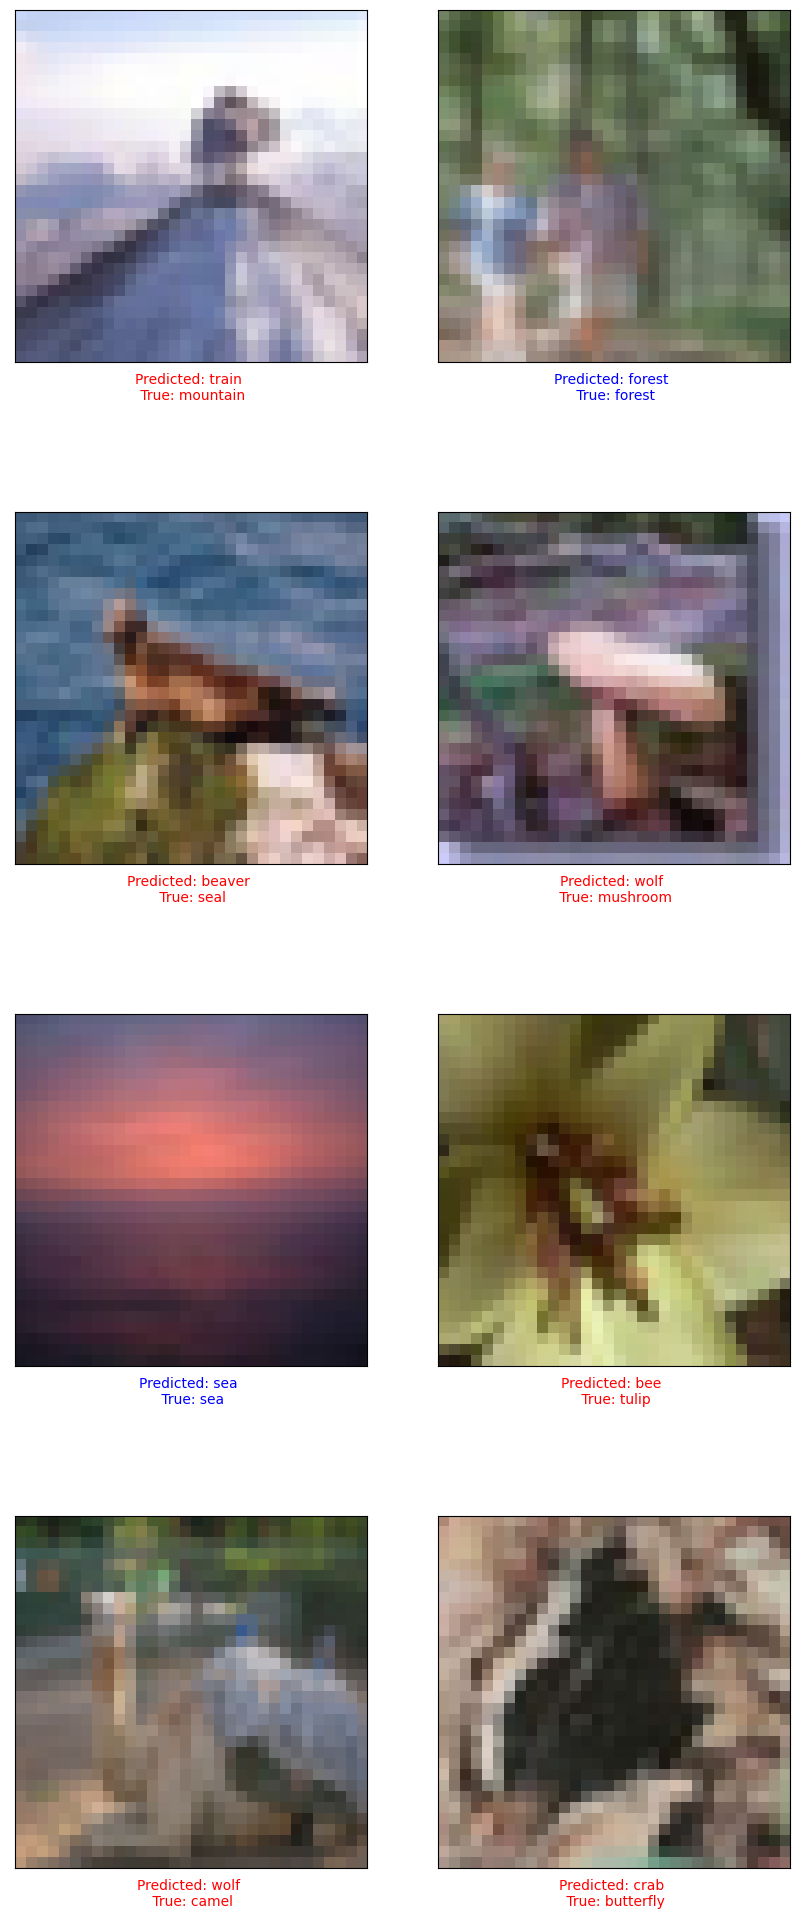

In [12]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = y_test[i]

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label[0]]}", color=color)
plt.show()

# The FNet model

In [13]:
class FNetLayer(tf.keras.layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.ffn = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                tf.keras.layers.Dropout(rate=dropout_rate),
                tf.keras.layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

# Build, train, and evaluate the FNet model

In [14]:
fnet_blocks = tf.keras.Sequential(
    [FNetLayer(CFG.num_patches, CFG.embedding_dim, CFG.dropout_rate) for _ in range(CFG.num_blocks)]
)

fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

Epoch 1/200
352/352 [==============================] - 4s 8ms/step - loss: 4.2921 - acc: 0.0490 - top5-acc: 0.1769 - val_loss: 4.1127 - val_acc: 0.0700 - val_top5-acc: 0.2240 - lr: 0.0050
Epoch 2/200
352/352 [==============================] - 3s 7ms/step - loss: 4.0151 - acc: 0.0789 - top5-acc: 0.2574 - val_loss: 3.9257 - val_acc: 0.0992 - val_top5-acc: 0.2896 - lr: 0.0050
Epoch 3/200
352/352 [==============================] - 3s 7ms/step - loss: 3.9237 - acc: 0.0954 - top5-acc: 0.2881 - val_loss: 3.8395 - val_acc: 0.1132 - val_top5-acc: 0.3184 - lr: 0.0050
Epoch 4/200
352/352 [==============================] - 3s 7ms/step - loss: 3.8523 - acc: 0.1053 - top5-acc: 0.3117 - val_loss: 3.8099 - val_acc: 0.1170 - val_top5-acc: 0.3344 - lr: 0.0050
Epoch 5/200
352/352 [==============================] - 3s 7ms/step - loss: 3.8168 - acc: 0.1112 - top5-acc: 0.3199 - val_loss: 3.7499 - val_acc: 0.1320 - val_top5-acc: 0.3428 - lr: 0.0050
Epoch 6/200
352/352 [==============================] - 3s 7m

Epoch 19/200
352/352 [==============================] - 3s 7ms/step - loss: 3.1886 - acc: 0.2190 - top5-acc: 0.5051 - val_loss: 3.1227 - val_acc: 0.2316 - val_top5-acc: 0.5270 - lr: 0.0050
Epoch 20/200
352/352 [==============================] - 3s 7ms/step - loss: 3.1672 - acc: 0.2206 - top5-acc: 0.5083 - val_loss: 3.0660 - val_acc: 0.2482 - val_top5-acc: 0.5404 - lr: 0.0050
Epoch 21/200
352/352 [==============================] - 3s 7ms/step - loss: 3.1338 - acc: 0.2291 - top5-acc: 0.5176 - val_loss: 3.0454 - val_acc: 0.2440 - val_top5-acc: 0.5326 - lr: 0.0050
Epoch 22/200
352/352 [==============================] - 3s 7ms/step - loss: 3.1178 - acc: 0.2341 - top5-acc: 0.5213 - val_loss: 3.0129 - val_acc: 0.2520 - val_top5-acc: 0.5396 - lr: 0.0050
Epoch 23/200
352/352 [==============================] - 3s 7ms/step - loss: 3.0889 - acc: 0.2377 - top5-acc: 0.5307 - val_loss: 3.0170 - val_acc: 0.2508 - val_top5-acc: 0.5548 - lr: 0.0050
Epoch 24/200
352/352 [==============================] -

352/352 [==============================] - 3s 7ms/step - loss: 2.4915 - acc: 0.3552 - top5-acc: 0.6733 - val_loss: 2.5329 - val_acc: 0.3546 - val_top5-acc: 0.6580 - lr: 0.0025
Epoch 63/200
352/352 [==============================] - 3s 7ms/step - loss: 2.4710 - acc: 0.3604 - top5-acc: 0.6766 - val_loss: 2.5206 - val_acc: 0.3608 - val_top5-acc: 0.6700 - lr: 0.0025
Epoch 64/200
352/352 [==============================] - 3s 7ms/step - loss: 2.4636 - acc: 0.3614 - top5-acc: 0.6789 - val_loss: 2.4607 - val_acc: 0.3632 - val_top5-acc: 0.6840 - lr: 0.0025
Epoch 65/200
352/352 [==============================] - 3s 7ms/step - loss: 2.4515 - acc: 0.3638 - top5-acc: 0.6815 - val_loss: 2.4516 - val_acc: 0.3616 - val_top5-acc: 0.6800 - lr: 0.0025
Epoch 66/200
352/352 [==============================] - 3s 7ms/step - loss: 2.4437 - acc: 0.3632 - top5-acc: 0.6843 - val_loss: 2.4670 - val_acc: 0.3676 - val_top5-acc: 0.6816 - lr: 0.0025
Epoch 67/200
352/352 [==============================] - 3s 7ms/step 

313/313 [==============================] - 1s 2ms/step - loss: 2.1176 - acc: 0.4406 - top5-acc: 0.7424
Test accuracy: 44.06%
Test top 5 accuracy: 74.24%


1/1 [==============================] - 0s 12ms/step


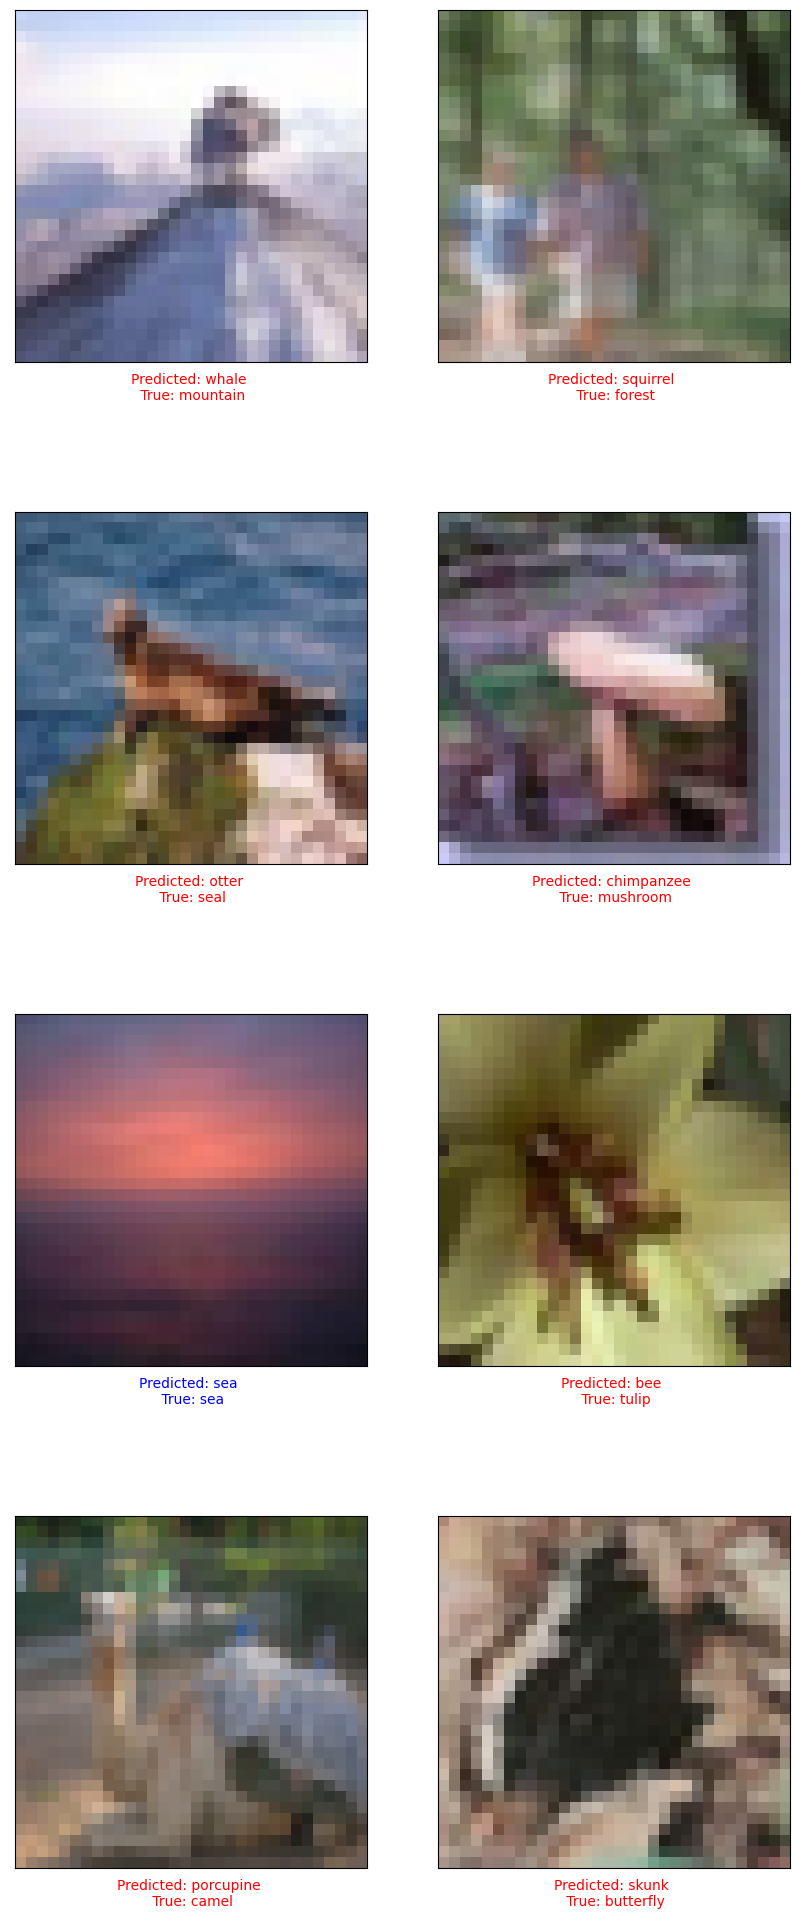

In [15]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = y_test[i]

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label[0]]}", color=color)
plt.show()

# The gMLP model

In [17]:
class gMLPLayer(tf.keras.layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.channel_projection1 = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=CFG.embedding_dim * 2),
                tfa.layers.GELU(),
                tf.keras.layers.Dropout(rate=CFG.dropout_rate),
            ]
        )

        self.channel_projection2 = tf.keras.layers.Dense(units=CFG.embedding_dim)

        self.spatial_projection = tf.keras.layers.Dense(
            units=CFG.num_patches, bias_initializer="Ones"
        )

        self.normalize1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected


# Build, train, and evaluate the gMLP model

In [18]:
gmlp_blocks = tf.keras.Sequential(
    [gMLPLayer(CFG.num_patches, CFG.embedding_dim, CFG.dropout_rate) for _ in range(CFG.num_blocks)]
)

gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

Epoch 1/200
352/352 [==============================] - 5s 10ms/step - loss: 4.0361 - acc: 0.0820 - top5-acc: 0.2615 - val_loss: 3.7791 - val_acc: 0.1194 - val_top5-acc: 0.3386 - lr: 0.0050
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 3.5772 - acc: 0.1490 - top5-acc: 0.3994 - val_loss: 3.4582 - val_acc: 0.1766 - val_top5-acc: 0.4260 - lr: 0.0050
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 3.3521 - acc: 0.1862 - top5-acc: 0.4587 - val_loss: 3.2578 - val_acc: 0.2158 - val_top5-acc: 0.4918 - lr: 0.0050
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 3.1861 - acc: 0.2165 - top5-acc: 0.5062 - val_loss: 3.0430 - val_acc: 0.2520 - val_top5-acc: 0.5450 - lr: 0.0050
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 3.0515 - acc: 0.2412 - top5-acc: 0.5413 - val_loss: 2.9447 - val_acc: 0.2748 - val_top5-acc: 0.5740 - lr: 0.0050
Epoch 6/200
352/352 [==============================] - 3s 9

352/352 [==============================] - 3s 9ms/step - loss: 1.6428 - acc: 0.5414 - top5-acc: 0.8413 - val_loss: 2.1418 - val_acc: 0.4734 - val_top5-acc: 0.7788 - lr: 0.0017
Epoch 45/200
352/352 [==============================] - 3s 9ms/step - loss: 1.6365 - acc: 0.5424 - top5-acc: 0.8410 - val_loss: 2.1246 - val_acc: 0.4810 - val_top5-acc: 0.7704 - lr: 0.0017
Epoch 46/200
352/352 [==============================] - 3s 9ms/step - loss: 1.5581 - acc: 0.5621 - top5-acc: 0.8519 - val_loss: 2.0544 - val_acc: 0.4922 - val_top5-acc: 0.7826 - lr: 0.0012
Epoch 47/200
352/352 [==============================] - 3s 9ms/step - loss: 1.5419 - acc: 0.5680 - top5-acc: 0.8551 - val_loss: 2.0957 - val_acc: 0.4910 - val_top5-acc: 0.7814 - lr: 0.0012
Epoch 48/200
352/352 [==============================] - 3s 9ms/step - loss: 1.5357 - acc: 0.5668 - top5-acc: 0.8566 - val_loss: 2.0920 - val_acc: 0.4922 - val_top5-acc: 0.7754 - lr: 0.0012
Epoch 49/200
352/352 [==============================] - 3s 9ms/step 

1/1 [==============================] - 0s 13ms/step


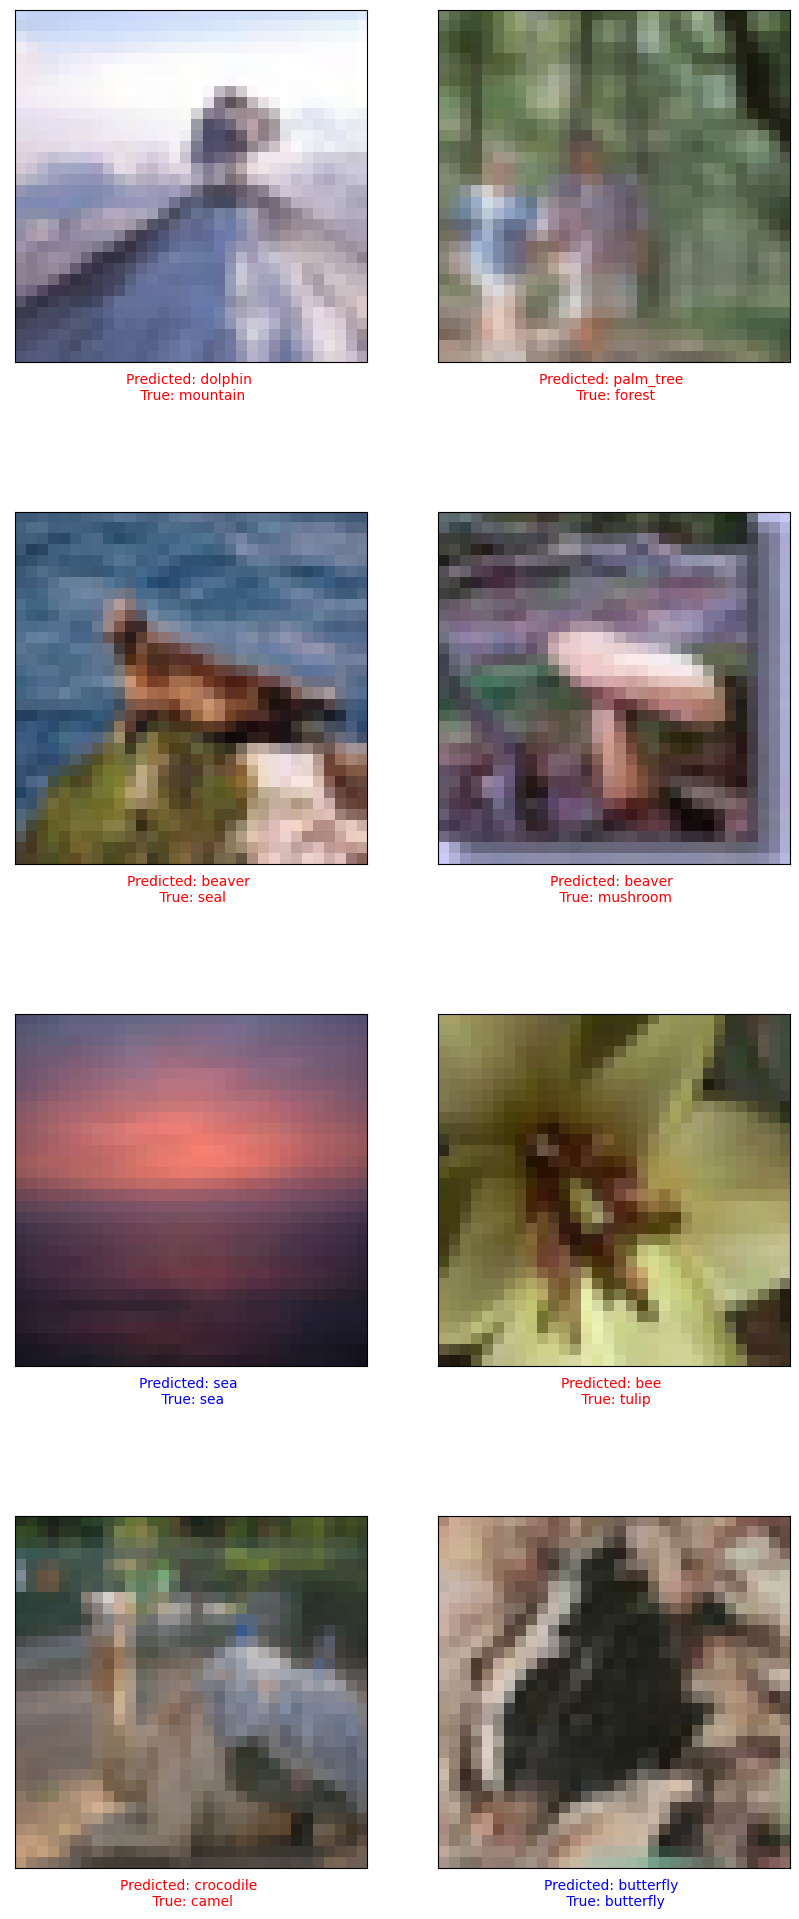

In [19]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = y_test[i]

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label[0]]}", color=color)
plt.show()